In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Bidirectional, Dense, SimpleRNN
import tensorflow as tf
import os
from timeit import default_timer as timer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [2]:
# Load the dataset
shampoo_data = pd.read_csv("../shampoo_sales.csv")

# Display the first few rows of the dataset
print(shampoo_data.head())

  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3


In [3]:
shampoo_series = shampoo_data['Sales'].values.astype(float)


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
shampoo_series_scaled = scaler.fit_transform(shampoo_series.reshape(-1, 1))

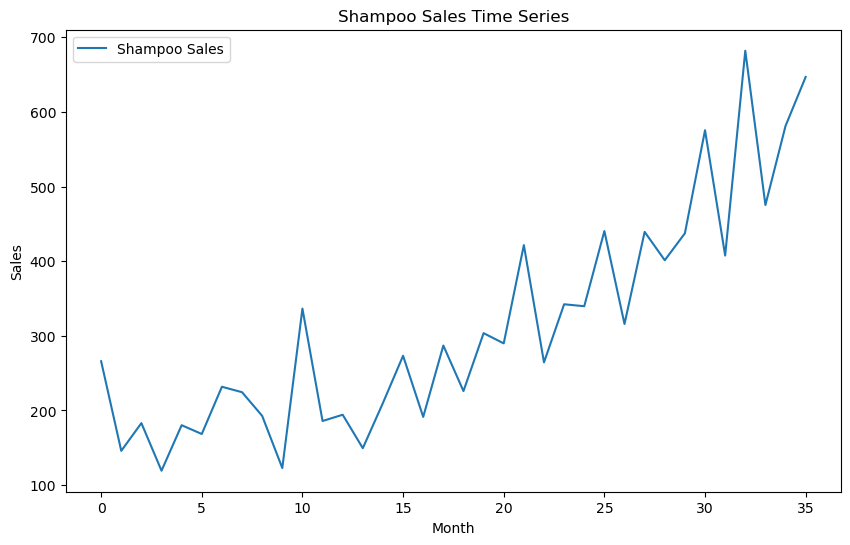

In [4]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(shampoo_series, label='Shampoo Sales')
plt.title('Shampoo Sales Time Series')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [5]:
# Function to create the dataset with input features and labels
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back), 0])
        y.append(series[i + look_back, 0])
    return np.array(X), np.array(y)

In [6]:
look_back = 7  # You can experiment with different values
X, y = create_dataset(shampoo_series_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [7]:
mse = []
mae = []  
rmse = []
r2 = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(X_test)
    index = []

    # Evaluate the model on training and testing data
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    rmse.append(test_rmse)
    mse.append(metrics.mean_squared_error(y_test, y_pred))
    mae.append((metrics.mean_absolute_error(y_test, y_pred)))
    r2.append(metrics.r2_score(y_test, y_pred))


In [8]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [9]:
model = Sequential([
    Bidirectional(SimpleRNN(units=50, return_sequences=True, input_shape=(X.shape[1], 1))),
    Bidirectional(SimpleRNN(units=50, return_sequences=True)),
    Bidirectional(SimpleRNN(units=50, return_sequences=True)),
    Bidirectional(SimpleRNN(units=50)),
    Dense(units=1)
])
cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="mse", metrics=["MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(X_train, y_train, batch_size=8, epochs=25, validation_data=(X_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/25
3/3 [==============================] - 2s 346ms/step - loss: 0.6571 - mean_absolute_error: 0.6407 - root_mean_squared_error: 0.8106 - mean_squared_error: 0.6571 - val_loss: 0.8955 - val_mean_absolute_error: 0.8938 - val_root_mean_squared_error: 0.9463 - val_mean_squared_error: 0.8955
Epoch 2/25
3/3 [==============================] - 0s 20ms/step - loss: 0.6198 - mean_absolute_error: 0.6640 - root_mean_squared_error: 0.7873 - mean_squared_error: 0.6198 - val_loss: 0.3107 - val_mean_absolute_error: 0.4870 - val_root_mean_squared_error: 0.5574 - val_mean_squared_error: 0.3107
Epoch 3/25
3/3 [==============================] - 0s 19ms/step - loss: 0.1858 - mean_absolute_error: 0.3667 - root_mean_squared_error: 0.4310 - mean_squared_error: 0.1858 - val_loss: 0.4791 - val_mean_absolute_error: 0.6592 - val_root_mean_squared_error: 0.6922 - val_mean_squared_error: 0.4791
Epoch 4/25
3/3 [==============================] - 0s 19ms/step - loss: 0.0756 - mean_absolute_error: 0.2334 - root

In [10]:
time_took_to_run = sum(cb.logs)
print(time_took_to_run)

3.454490250442177


In [11]:
# Predict using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

1/1 [==============================] - 0s 10ms/step


In [12]:
# Evaluate the model on training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Training RMSE: {train_rmse}')
print(f"Testing RMSE: {test_rmse}")
print("MSE (validation): " + str(mean_squared_error(y_test, test_predictions)))
print("MAE (validation): " + str(mean_absolute_error(y_test, test_predictions)))
print(f"R2 Validation: {metrics.r2_score(y_test, test_predictions)}" )


Training RMSE: 0.047334793877415425
Testing RMSE: 0.2888664951934517
MSE (validation): 0.08344385204534845
MAE (validation): 0.2461796342597443
R2 Validation: -1.9621501554605492


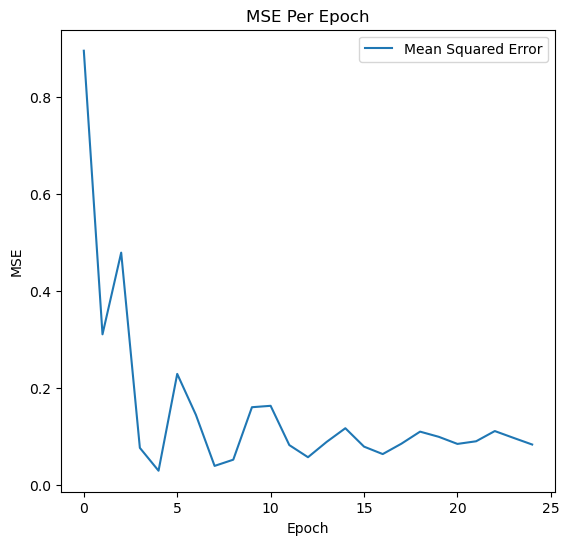

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(mse, label="Mean Squared Error")
plt.title('MSE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

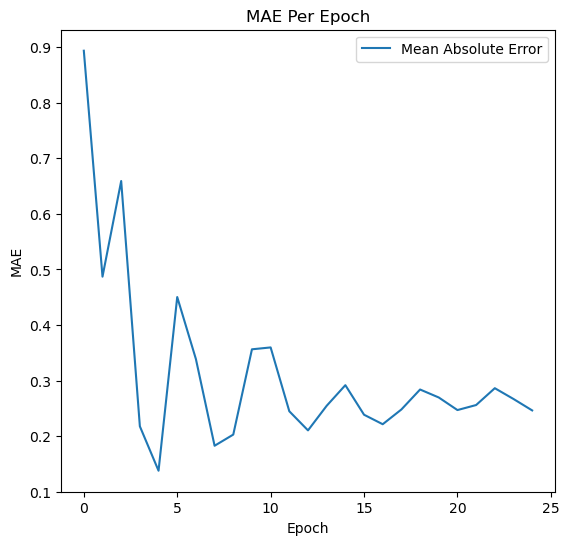

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(mae, label="Mean Absolute Error")
plt.title('MAE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

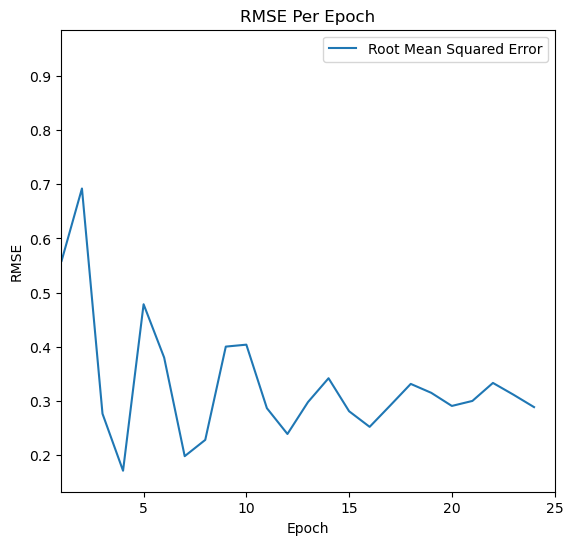

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(rmse, label="Root Mean Squared Error")
plt.title('RMSE Per Epoch')
plt.xlabel('Epoch')
plt.xlim(1,25)
plt.ylabel('RMSE')
plt.legend()

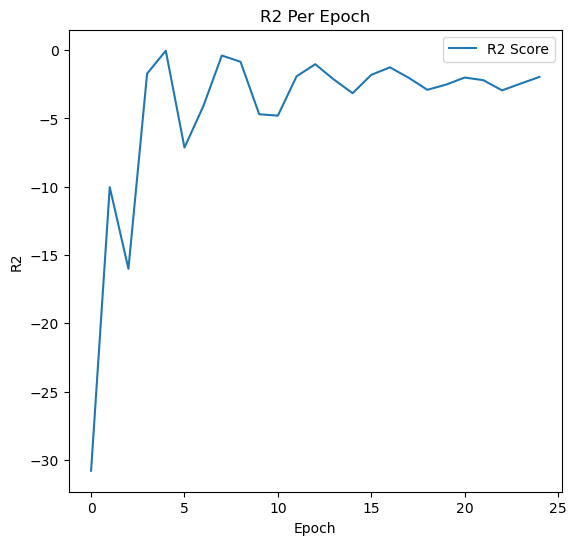

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(r2, label="R2 Score")
plt.title('R2 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

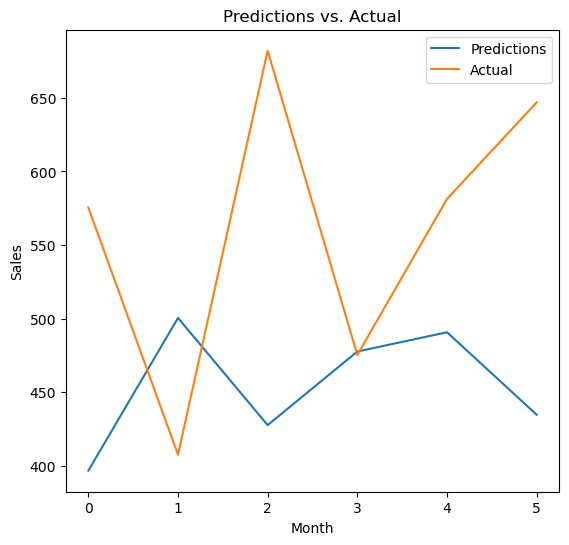

In [18]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(scaler.inverse_transform(test_predictions.reshape(-1,1)), label="Predictions")
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.title('Predictions vs. Actual')
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
